# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=55,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_16-08-07/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4677 | MulticlassF1Score=0.2088
Batch-30 : CrossEntropyLoss=2.4586 | MulticlassF1Score=0.2492
Batch-45 : CrossEntropyLoss=2.4146 | MulticlassF1Score=0.2981
Batch-60 : CrossEntropyLoss=2.3849 | MulticlassF1Score=0.3364
Batch-75 : CrossEntropyLoss=2.3940 | MulticlassF1Score=0.3826
Batch-90 : CrossEntropyLoss=2.3985 | MulticlassF1Score=0.4147
Batch-105: CrossEntropyLoss=2.4001 | MulticlassF1Score=0.4365
Batch-120: CrossEntropyLoss=2.3828 | MulticlassF1Score=0.4551
Batch-135: CrossEntropyLoss=2.3646 | MulticlassF1Score=0.4708
Batch-150: CrossEntropyLoss=2.3627 | MulticlassF1Score=0.4828
Batch-165: CrossEntropyLoss=2.3761 | MulticlassF1Score=0.4932
Batch-180: CrossEntropyLoss=2.3634 | MulticlassF1Score=0.5021
Batch-195: CrossEntropyLoss=2.3466 | MulticlassF1Score=0.5106
Batch-210: CrossEntropyLoss=2.3400 | MulticlassF1Score=0.5215
Batch-225: CrossEntropyLoss=2.3391 | MulticlassF1Score=0.5311
Batch-226: CrossEntropyLoss=2.3440 | MulticlassF1Score=0.5314

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3513 | MulticlassF1Score=0.6817
Batch-30 : CrossEntropyLoss=2.3524 | MulticlassF1Score=0.6811
Batch-45 : CrossEntropyLoss=2.3456 | MulticlassF1Score=0.6837
Batch-60 : CrossEntropyLoss=2.3421 | MulticlassF1Score=0.6844
Batch-63 : CrossEntropyLoss=2.3373 | MulticlassF1Score=0.6843

Training   : Mean CrossEntropyLoss = 2.4057 | Mean MulticlassF1Score = 0.4089
Validation : Mean CrossEntropyLoss = 2.3488 | Mean MulticlassF1Score = 0.6809

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3451 | MulticlassF1Score=0.7056
Batch-30 : CrossEntropyLoss=2.3479 | MulticlassF1Score=0.7056
Batch-45 : CrossEntropyLoss=2.3342 | MulticlassF1Score=0.7119
Batch-60 : CrossEntropyLoss=2.3367 | MulticlassF1Score=0.7139
Batch-75 : CrossEntropyLoss=2.3303 | MulticlassF1Score=0.7138
Batch-90 : CrossEntropyLoss=2.3315 | MulticlassF1Score=0.7145
Batch-105: CrossEntropyLoss=2.3254 | MulticlassF1Score=0.7165
Batch-120: CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7184
Batch-135: CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7225
Batch-150: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7269
Batch-165: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.7312
Batch-180: CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7361
Batch-195: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7402
Batch-210: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7443
Batch-225: CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7469
Batch-226: CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7901
Batch-30 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.7879
Batch-45 : CrossEntropyLoss=2.3248 | MulticlassF1Score=0.7898
Batch-60 : CrossEntropyLoss=2.3229 | MulticlassF1Score=0.7892
Batch-63 : CrossEntropyLoss=2.3191 | MulticlassF1Score=0.7894

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3273 | Mean MulticlassF1Score = 0.7219
Validation : Mean CrossEntropyLoss = 2.3139 | Mean MulticlassF1Score = 0.7906

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3204 | MulticlassF1Score=0.7912
Batch-30 : CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7898
Batch-45 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7905
Batch-60 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7915
Batch-75 : CrossEntropyLoss=2.3214 | MulticlassF1Score=0.7926
Batch-90 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.7928
Batch-105: CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7940
Batch-120: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.7929
Batch-135: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7923
Batch-150: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7932
Batch-165: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7950
Batch-180: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.7966
Batch-195: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.7981
Batch-210: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.7991
Batch-225: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8004
Batch-226: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8005

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8083
Batch-30 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8095
Batch-45 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8103
Batch-60 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8128
Batch-63 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8133

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3099 | Mean MulticlassF1Score = 0.7938
Validation : Mean CrossEntropyLoss = 2.3060 | Mean MulticlassF1Score = 0.8088

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8147
Batch-30 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8184
Batch-45 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8221
Batch-60 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8239
Batch-75 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8250
Batch-90 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8266
Batch-105: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8258
Batch-120: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8259
Batch-135: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8266
Batch-150: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8277
Batch-165: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8278
Batch-180: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8280
Batch-195: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8277
Batch-210: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8278
Batch-225: CrossEntropyLoss=2.3145 | MulticlassF1Score=0.8273
Batch-226: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8272

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8277
Batch-30 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.8271
Batch-45 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8272
Batch-60 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8260
Batch-63 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8244
Validation : Mean CrossEntropyLoss = 2.3019 | Mean MulticlassF1Score = 0.8259

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8348
Batch-30 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8322
Batch-45 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8317
Batch-60 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8329
Batch-75 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8317
Batch-90 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8322
Batch-105: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8321
Batch-120: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8316
Batch-135: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8312
Batch-150: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.8309
Batch-165: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8308
Batch-180: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8308
Batch-195: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8306
Batch-210: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8306
Batch-225: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8308
Batch-226: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8308

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8275
Batch-30 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8279
Batch-45 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8296
Batch-60 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8284
Batch-63 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8318
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8285

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8352
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8353
Batch-45 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8352
Batch-60 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8337
Batch-75 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8349
Batch-90 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8345
Batch-105: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8335
Batch-120: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8332
Batch-135: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8335
Batch-150: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8334
Batch-165: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8335
Batch-180: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8339
Batch-195: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8336
Batch-210: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8330
Batch-225: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8330
Batch-226: CrossEntropyLoss=2.3170 | MulticlassF1Score=0.8329

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8355
Batch-30 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8309
Batch-45 : CrossEntropyLoss=2.3023 | MulticlassF1Score=0.8287
Batch-60 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8283
Batch-63 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8341
Validation : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8315

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8351
Batch-30 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8362
Batch-45 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.8337
Batch-60 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8335
Batch-75 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8334
Batch-90 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8342
Batch-105: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8356
Batch-120: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8353
Batch-135: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8365
Batch-150: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8374
Batch-165: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8380
Batch-180: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8378
Batch-195: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8386
Batch-210: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8391
Batch-225: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8389
Batch-226: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8315
Batch-30 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8337
Batch-45 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8349
Batch-60 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8361
Batch-63 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8366

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2975 | Mean MulticlassF1Score = 0.8363
Validation : Mean CrossEntropyLoss = 2.2984 | Mean MulticlassF1Score = 0.8336

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8423
Batch-30 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8418
Batch-45 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8426
Batch-60 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8426
Batch-75 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8419
Batch-90 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8426
Batch-105: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8428
Batch-120: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8429
Batch-135: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8431
Batch-150: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8435
Batch-165: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8436
Batch-180: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8438
Batch-195: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8439
Batch-210: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8439
Batch-225: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8432
Batch-226: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8433

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8401
Batch-30 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8441
Batch-45 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8439
Batch-60 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8446
Batch-63 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8449

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2961 | Mean MulticlassF1Score = 0.8429
Validation : Mean CrossEntropyLoss = 2.2959 | Mean MulticlassF1Score = 0.8430

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8556
Batch-30 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8563
Batch-45 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8575
Batch-60 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8570
Batch-75 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8567
Batch-90 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8567
Batch-105: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8582
Batch-120: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8579
Batch-135: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8577
Batch-150: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8581
Batch-165: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8580
Batch-180: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8585
Batch-195: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8591
Batch-210: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8596
Batch-225: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8599
Batch-226: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8599

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8540
Batch-30 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8520
Batch-45 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8516
Batch-60 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8531
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8537

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2912 | Mean MulticlassF1Score = 0.8576
Validation : Mean CrossEntropyLoss = 2.2931 | Mean MulticlassF1Score = 0.8527

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8603
Batch-30 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8622
Batch-45 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8607
Batch-60 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8609
Batch-75 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8618
Batch-90 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8615
Batch-105: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8620
Batch-120: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8619
Batch-135: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8619
Batch-150: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8618
Batch-165: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8619
Batch-180: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8620
Batch-195: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8622
Batch-210: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8623
Batch-225: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8623
Batch-226: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8622

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8496
Batch-30 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8522
Batch-45 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8520
Batch-60 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8532
Batch-63 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8533

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2903 | Mean MulticlassF1Score = 0.8617
Validation : Mean CrossEntropyLoss = 2.2931 | Mean MulticlassF1Score = 0.8503

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8598
Batch-30 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8623
Batch-45 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8622
Batch-60 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8624
Batch-75 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8631
Batch-90 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8665
Batch-105: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8695
Batch-120: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8716
Batch-135: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8731
Batch-150: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8741
Batch-165: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8756
Batch-180: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8767
Batch-195: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8779
Batch-210: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8787
Batch-225: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8795
Batch-226: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8795

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8811
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8847
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8839
Batch-60 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8825
Batch-63 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8820

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2852 | Mean MulticlassF1Score = 0.8697
Validation : Mean CrossEntropyLoss = 2.2845 | Mean MulticlassF1Score = 0.8825

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8895
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8896
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8899
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8899
Batch-75 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8897
Batch-90 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8896
Batch-105: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8905
Batch-120: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8910
Batch-135: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8914
Batch-150: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8921
Batch-165: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8925
Batch-180: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8929
Batch-195: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8929
Batch-210: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8930
Batch-225: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8927
Batch-226: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8926

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8887
Batch-30 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8880
Batch-45 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8849
Batch-60 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8834
Batch-63 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8834

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8911
Validation : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8872

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8957
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8931
Batch-45 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8933
Batch-60 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8935
Batch-75 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8933
Batch-90 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.8940
Batch-105: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8939
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8945
Batch-135: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8949
Batch-150: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8947
Batch-165: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8950
Batch-180: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8951
Batch-195: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8953
Batch-210: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8950
Batch-225: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8949
Batch-226: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8949

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8862
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8870
Batch-60 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8854
Batch-63 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8850

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8944
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8869

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9026
Batch-30 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8995
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.8982
Batch-60 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.8988
Batch-75 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8987
Batch-90 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8977
Batch-105: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8971
Batch-120: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8972
Batch-135: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8971
Batch-150: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8972
Batch-165: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8974
Batch-180: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8972
Batch-195: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8973
Batch-210: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8969
Batch-225: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8968
Batch-226: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8969

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8897
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8862
Batch-45 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8874
Batch-60 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8862
Batch-63 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8859

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8983
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8867

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8942
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8963
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8968
Batch-60 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8972
Batch-75 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8973
Batch-90 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8979
Batch-105: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8976
Batch-120: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8984
Batch-135: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8988
Batch-150: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8989
Batch-165: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.8989
Batch-180: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8988
Batch-195: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8986
Batch-210: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8984
Batch-225: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.8985
Batch-226: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8985

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8887
Batch-30 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8889
Batch-45 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8885
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8887
Batch-63 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8886

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.8977
Validation : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8895

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9059
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9024
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9043
Batch-60 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.9025
Batch-75 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9021
Batch-90 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9028
Batch-105: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.9025
Batch-120: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9030
Batch-135: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9029
Batch-150: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9028
Batch-165: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.9027
Batch-180: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9025
Batch-195: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.9024
Batch-210: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9026
Batch-225: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9026
Batch-226: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9025

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8932
Batch-30 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8929
Batch-45 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8917
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8924
Batch-63 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8921

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2778 | Mean MulticlassF1Score = 0.9031
Validation : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8929

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9027
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9025
Batch-45 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9031
Batch-60 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9037
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9040
Batch-90 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9044
Batch-105: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9050
Batch-120: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9054
Batch-135: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9054
Batch-150: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9053
Batch-165: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9055
Batch-180: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9052
Batch-195: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9048
Batch-210: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9046
Batch-225: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.9046
Batch-226: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9046

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8919
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8913
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8928
Batch-63 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8929

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9044
Validation : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8915

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9081
Batch-30 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9052
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9049
Batch-60 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9049
Batch-75 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9050
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9039
Batch-105: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9040
Batch-120: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9050
Batch-135: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9047
Batch-150: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9050
Batch-165: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9055
Batch-180: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9058
Batch-195: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9059
Batch-210: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9060
Batch-225: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9060
Batch-226: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9060

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8874
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8919
Batch-45 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8928
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8937
Batch-63 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8936

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2766 | Mean MulticlassF1Score = 0.9056
Validation : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8910

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9105
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9111
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9166
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9185
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9207
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9221
Batch-105: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9229
Batch-120: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9243
Batch-135: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9250
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9255
Batch-165: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9261
Batch-180: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9267
Batch-195: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9271
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9277
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9278
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9278

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9133
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9194
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9193
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9190

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9216
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9174

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9367
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9353
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9346
Batch-75 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9348
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9355
Batch-105: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9351
Batch-120: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9356
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9358
Batch-150: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9359
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9356
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9356
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9353
Batch-210: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9350
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9349
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9349

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9194
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9200
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9183
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9184
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9187

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9356
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9193

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9323
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9342
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9348
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9360
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9358
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9365
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9363
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9361
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9362
Batch-150: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9363
Batch-165: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9356
Batch-180: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9351
Batch-195: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9353
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9352
Batch-225: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9353
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9353

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9213
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9197
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9197

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9351
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9209

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9357
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9362
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9355
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9344
Batch-75 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9356
Batch-90 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9358
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9355
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9361
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9362
Batch-150: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9362
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9363
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9366
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9366
Batch-210: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9364
Batch-225: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9367
Batch-226: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9196
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9202
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9207
Batch-63 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9207

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9361
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9200

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9353
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9363
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9365
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9361
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9365
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9367
Batch-105: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9368
Batch-120: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9378
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9378
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9375
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9373
Batch-195: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9371
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9373
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9372
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9372

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9197
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9197
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9199

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9367
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9218

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9367
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9368
Batch-75 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9364
Batch-90 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9365
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9368
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9368
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9373
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9372
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9375
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9376
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9375
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9377
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9374
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9224

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9375
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9393
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9394
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9397
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9393
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9397
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9394
Batch-150: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9389
Batch-165: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9386
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9386
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9386
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9386
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9385
Batch-226: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9385

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9154
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9165
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9182
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9202
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9386
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9167

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9382
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9386
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9389
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9396
Batch-90 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9393
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9395
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9396
Batch-180: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9395
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9394
Batch-225: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9396
Batch-226: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9397

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9174
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9204
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9220
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9392
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9205

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9510
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9540
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9570
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9582
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9590
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9589
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9584
Batch-135: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9585
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9588
Batch-165: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9592
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9593
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9594
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9595
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9598
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9436
Batch-63 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9438

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2601 | Mean MulticlassF1Score = 0.9567
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9446

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9649
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9656
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9646
Batch-60 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9637
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9637
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9628
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9627
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9625
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9623
Batch-150: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9623
Batch-165: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9625
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9626
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9626
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9625
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9625
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9626

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9427
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9430
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9432

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9633
Validation : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9424

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9638
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9627
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9634
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9639
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9641
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9638
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9636
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9637
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9637
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9636
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9633
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9633
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9633
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9632

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9459
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9457

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2589 | Mean MulticlassF1Score = 0.9636
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9451

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9645
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9643
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9659
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9658
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9661
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9658
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9654
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9655
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9657
Batch-165: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9653
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9651
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9651
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9650
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9650

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9457

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9655
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9449

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9666
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9656
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9648
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9646
Batch-90 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9646
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9649
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9649
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9649
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9651
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9652
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9653
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9654
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9655
Batch-226: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9655

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9455

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2582 | Mean MulticlassF1Score = 0.9652
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9454

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9653
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9647
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9657
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9657
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9655
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9655
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9656
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9658
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9658
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9658
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9451
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9451
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9454

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9656
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9456

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9672
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9675
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9675
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9515
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9487

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9677
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9691
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9680
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9459

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9669
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9682
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9684
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9524
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9492

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9672
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9693
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9696
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9699
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9490

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9698
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9698
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9699
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9697
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9511
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9516
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9504
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9499

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9738
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9734
Batch-45 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9725
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9712
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9477

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9707
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9473
Patience = 1/50❗

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9697
Batch-195: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9697
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9489

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9681
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9699
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9698
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9698
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9698
Batch-226: CrossEntropyLoss=2.2508 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9490

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9706
Batch-30 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9703
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9704
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9702
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9702
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9702
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9702

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9703
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9466

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9730
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9728
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9730
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9728
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9725
Batch-90 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9721
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9724
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9722
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9717
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9709
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9709

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9512
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9505
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9507
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9498

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9721
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9503

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9729
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9709
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9713
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9716
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9496

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9499

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9708
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9713
Batch-60 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9708
Batch-75 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9718
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9720
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9719
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9722
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9721
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9721
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9719
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9718
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9551
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9526
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9514
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9497
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9498

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9536

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9723
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9740
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9734
Batch-60 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9734
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9728
Batch-90 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9730
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9726
Batch-120: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9727
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9725
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9722
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9720
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9720
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9721
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9721
Batch-226: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9721

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9517
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9498

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9726
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9505

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9703
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9716
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9716
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9719
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9718
Batch-120: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9720
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9723
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9723
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9721
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9720
Batch-225: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9720
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9720

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9493
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9495

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9497
Patience = 2/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9736
Batch-30 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9724
Batch-45 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9721
Batch-60 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9726
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9720
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9717
Batch-105: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9719
Batch-165: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9719
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9719
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9717
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9515
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9511
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9497
Batch-63 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9495

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9720
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9509
Patience = 3/50❗

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9735
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9721
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9720
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9726
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9722
Batch-105: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9721
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9723
Batch-135: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9721
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9719
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9717
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9718
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9717
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9497
Batch-63 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9500

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9721
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9499

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9740
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9725
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9719
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9718
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9725
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9725
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9724
Batch-120: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9724
Batch-135: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9723
Batch-150: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9723
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9722
Batch-180: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9722
Batch-195: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9722
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9721
Batch-225: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9721
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9721

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9495

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9724
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9489

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9742
Batch-30 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9726
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9730
Batch-60 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9731
Batch-75 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9728
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9725
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9722
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9725
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9727
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9726
Batch-165: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9724
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9724
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9722
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9722
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9721
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9721

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2560 | Mean MulticlassF1Score = 0.9727
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9475

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2560
Best CrossEntropyLoss training    : 2.2632
Best MulticlassF1Score validation : 0.9727
Best MulticlassF1Score validation : 0.9475
Training duration                 : 2.6168 minutes.
Training date                     : 2022-10-19 11:10:16.171409+08:00


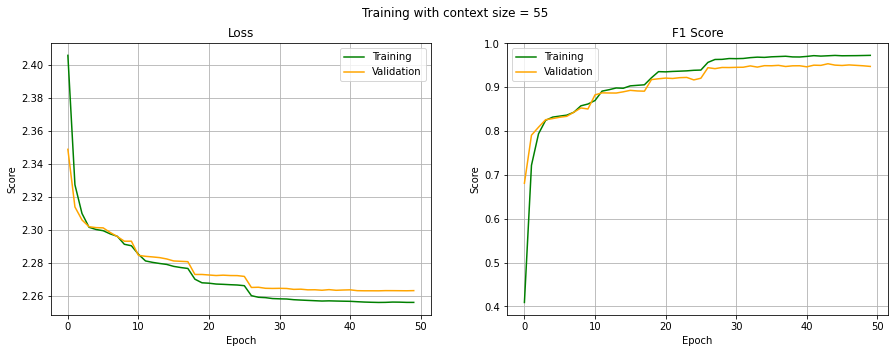

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9727, device='cuda:0'),
 tensor(0.9494, device='cuda:0'),
 tensor(0.9496, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9727, device='cuda:0'),
 tensor(0.9494, device='cuda:0'),
 tensor(0.9496, device='cuda:0'))

## Heatmap

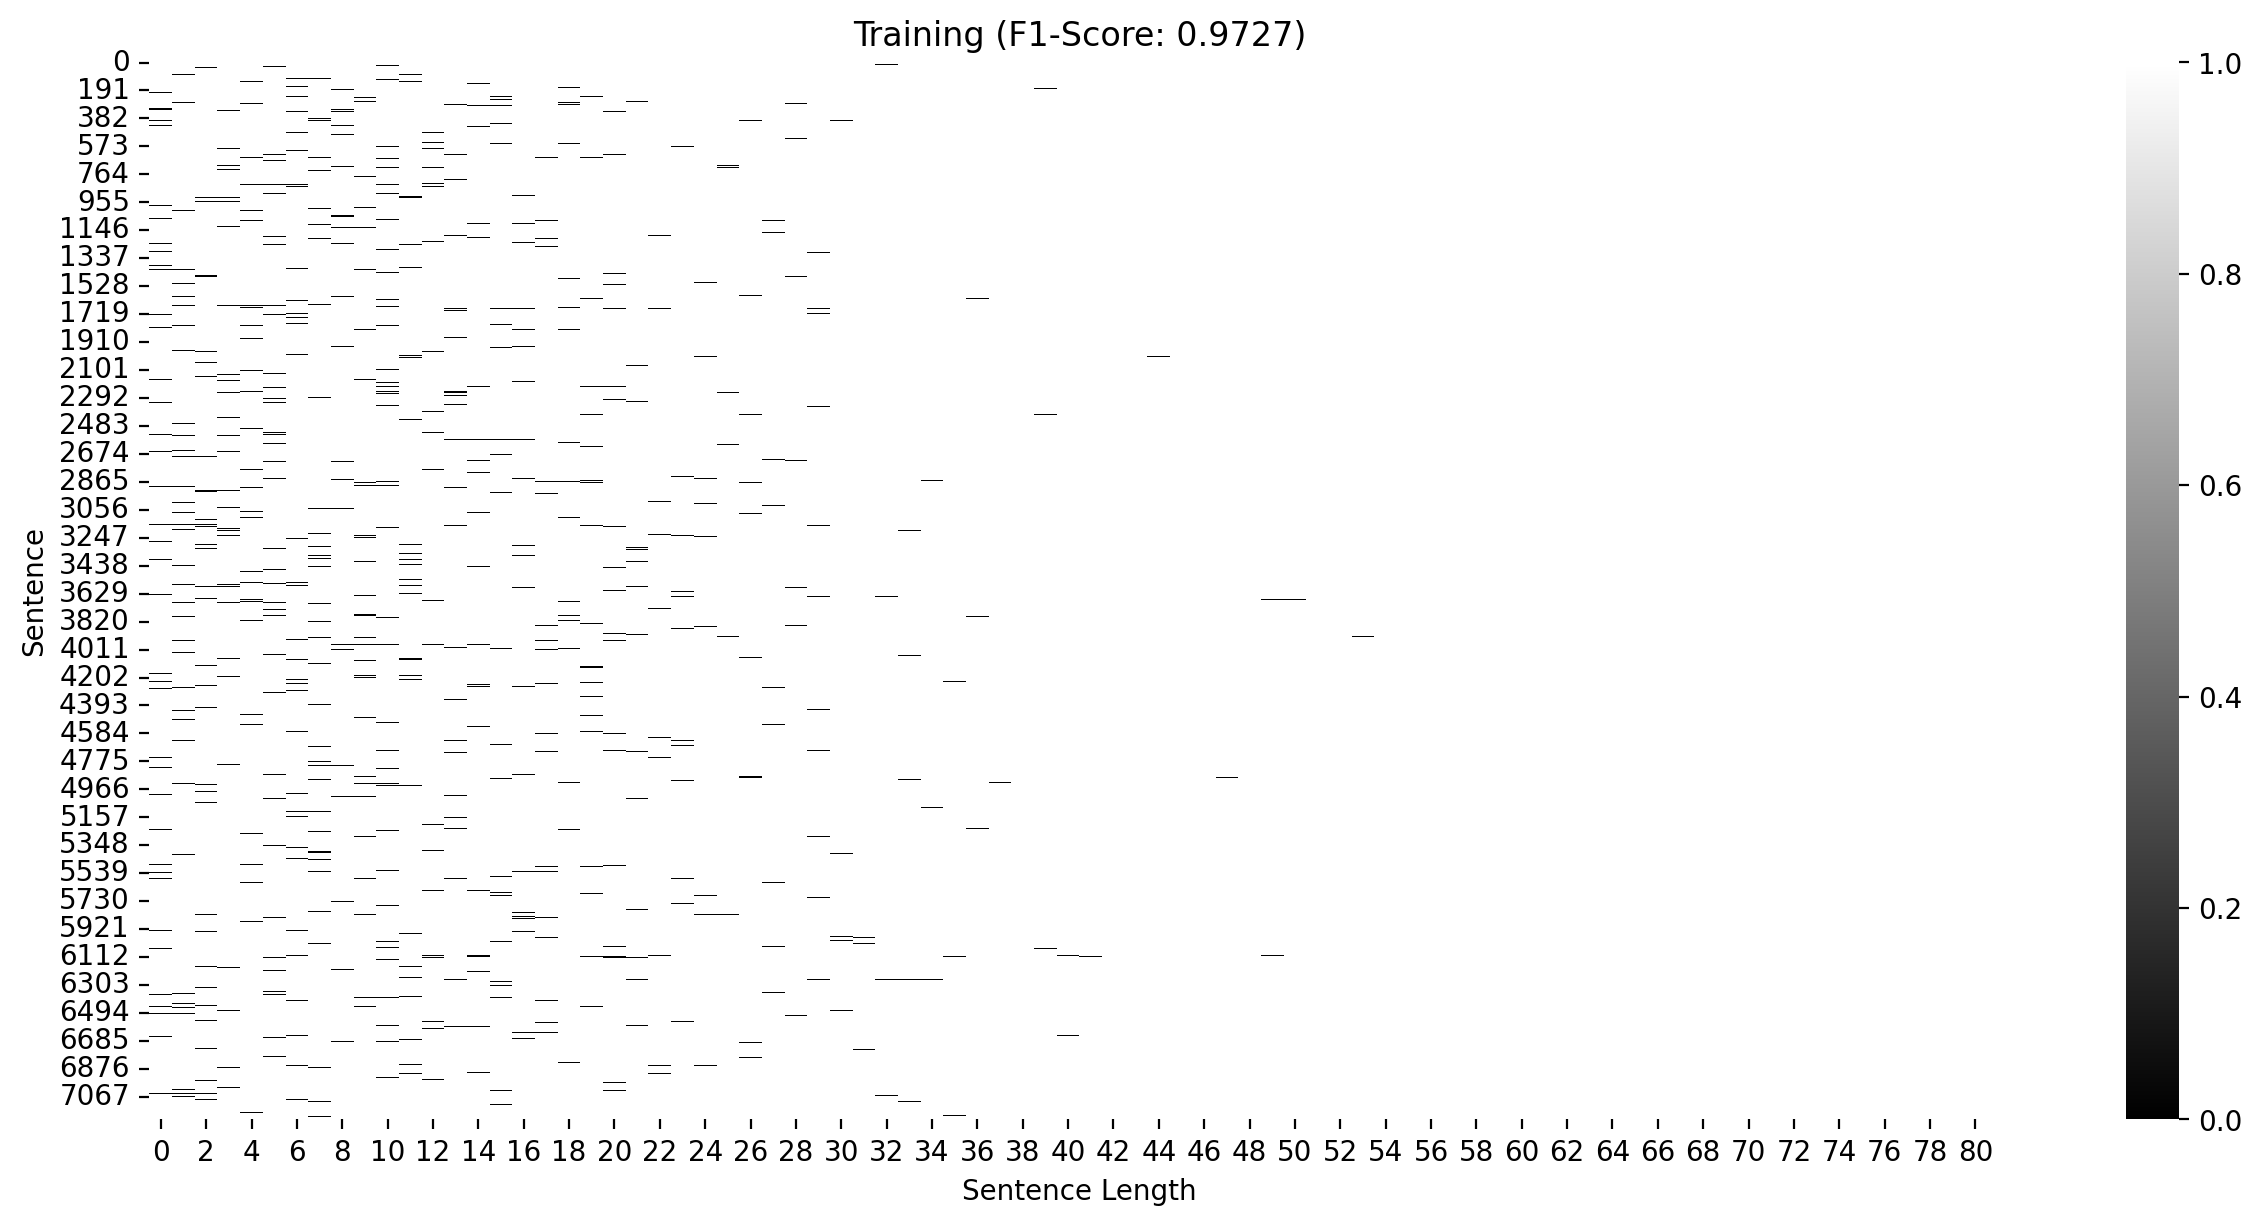

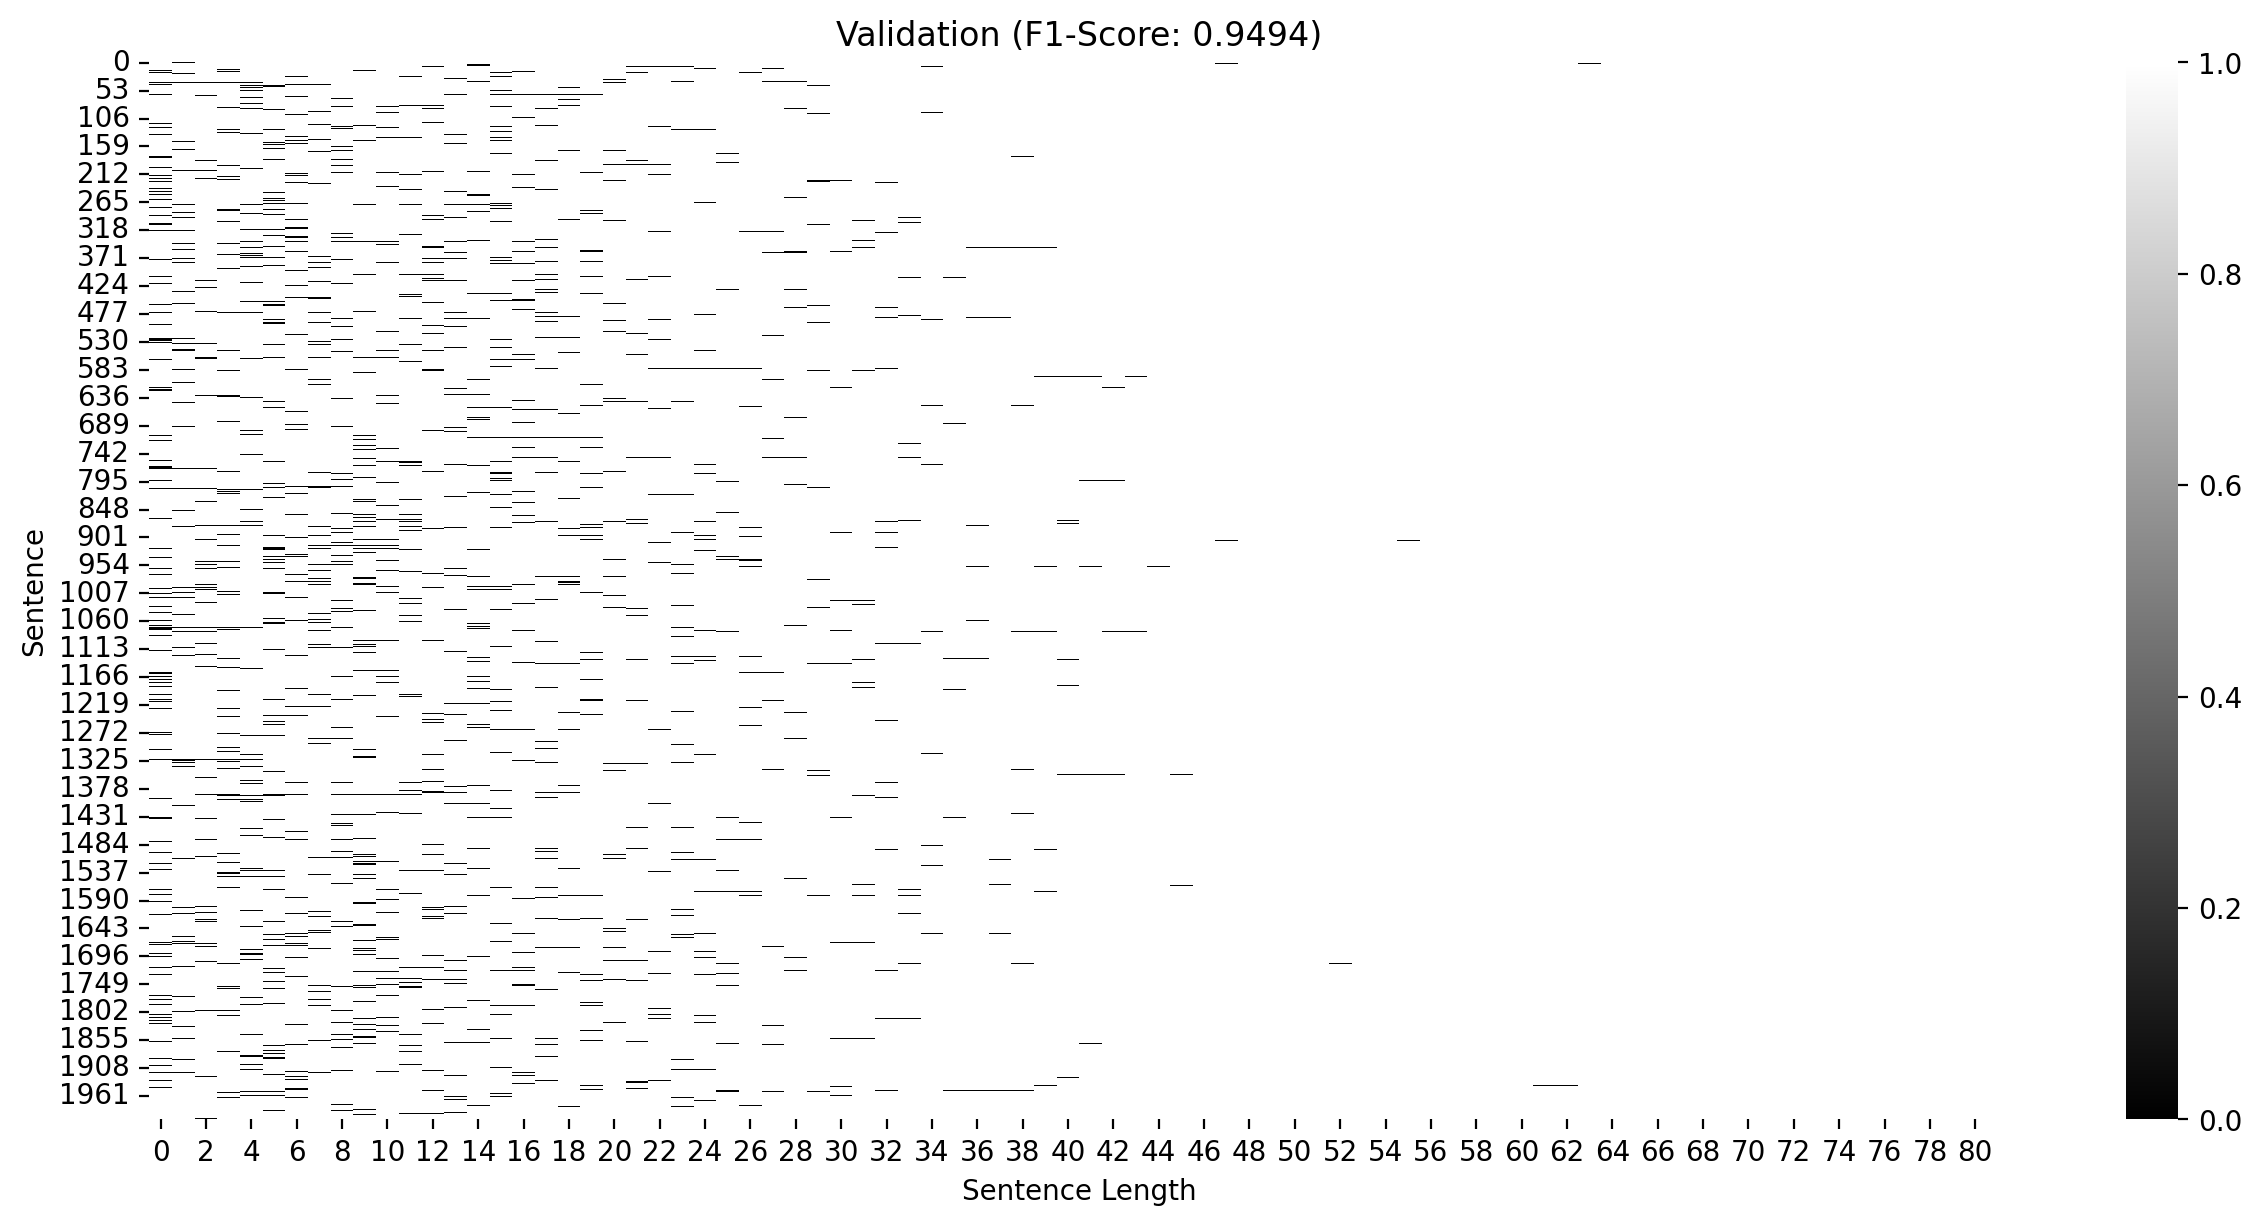

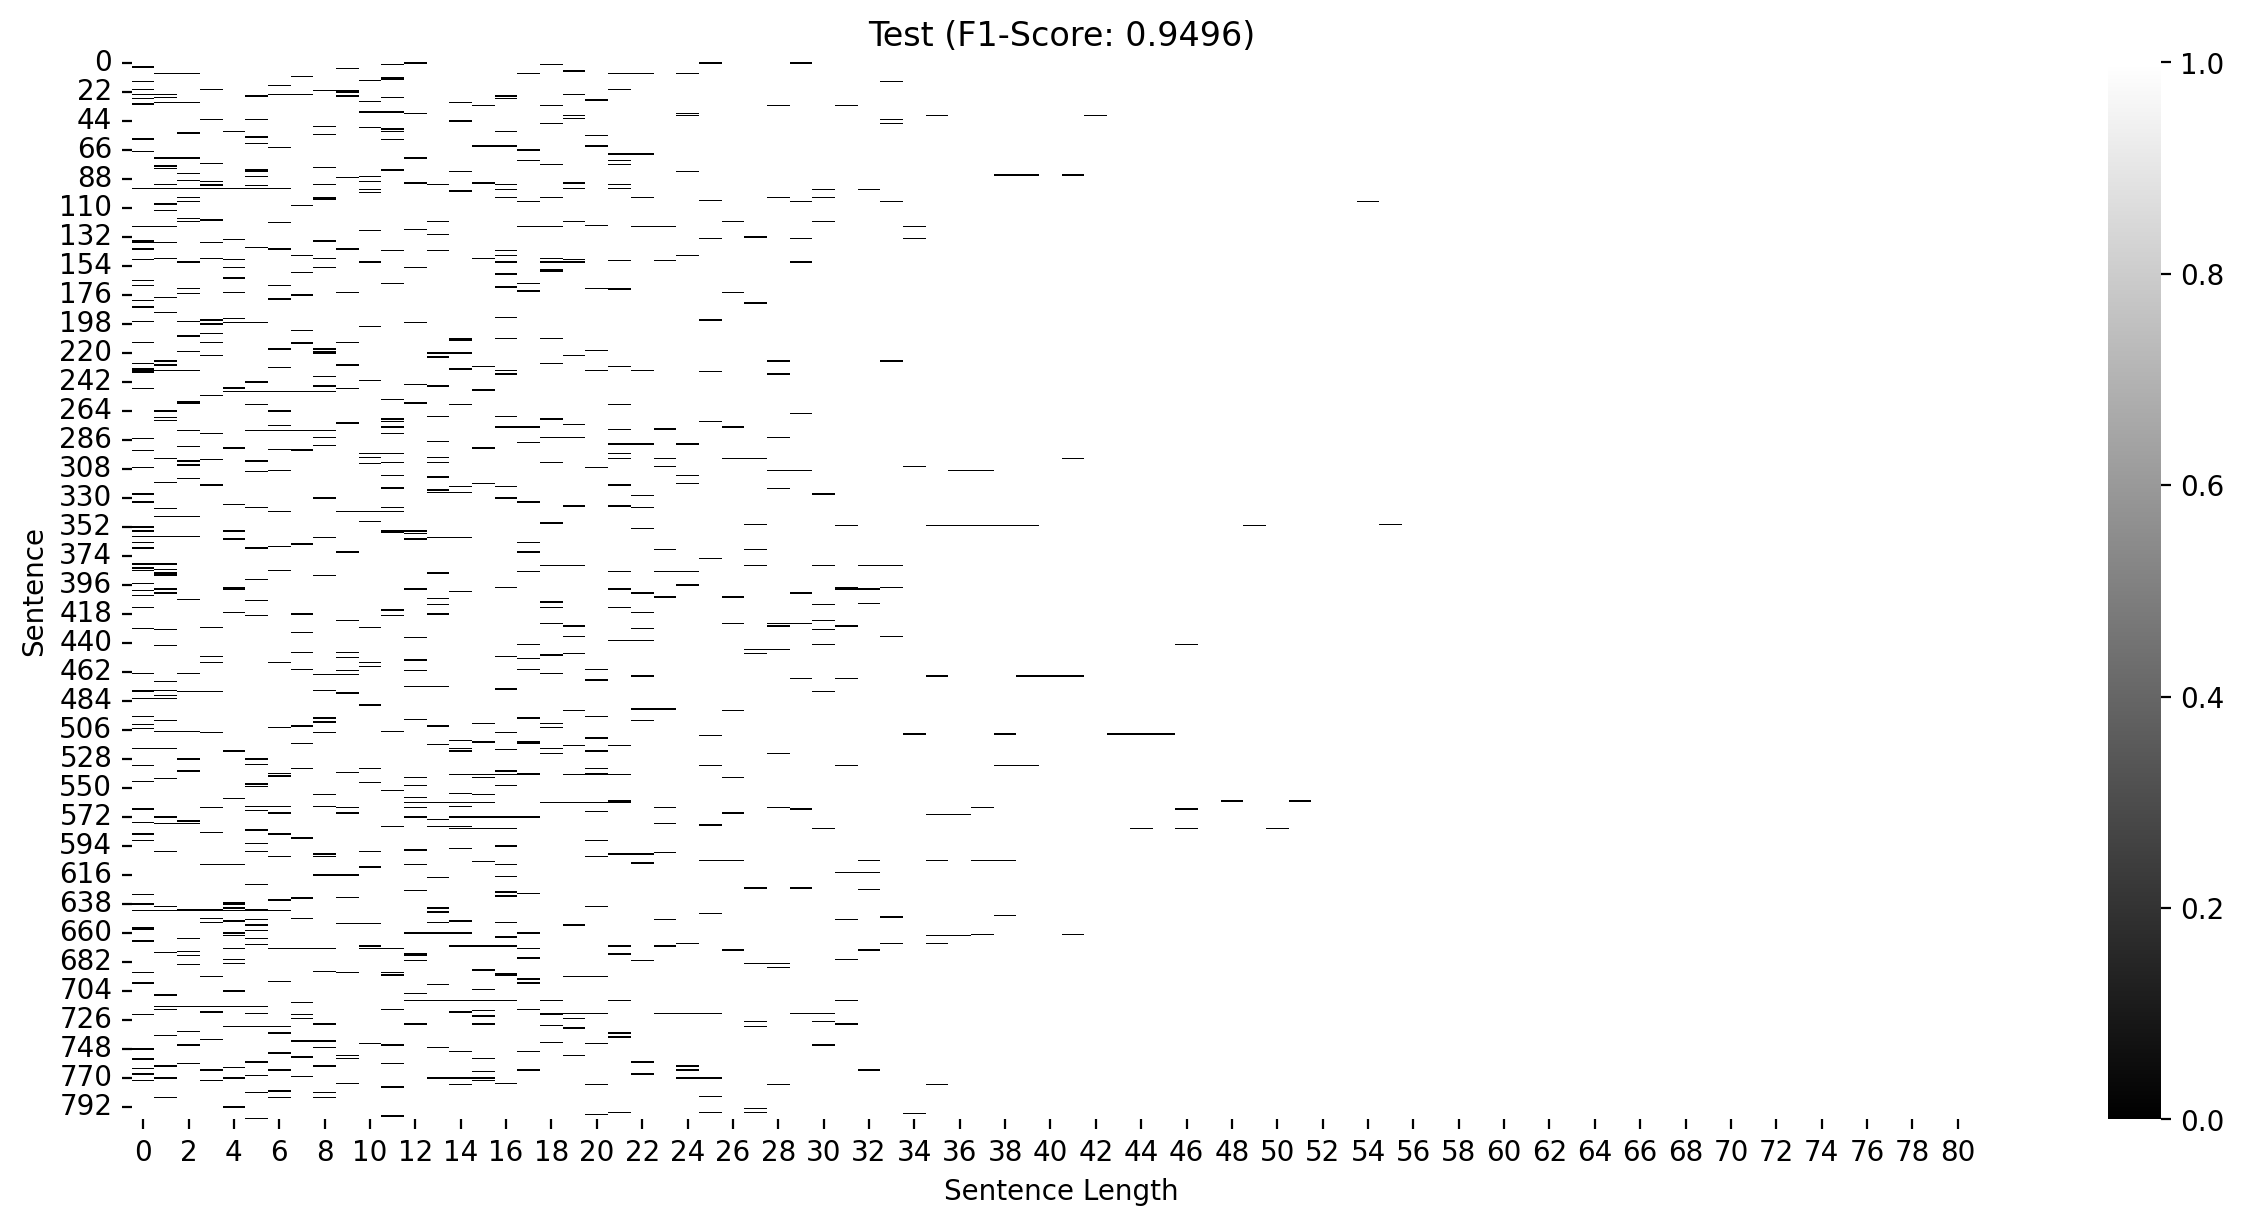

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


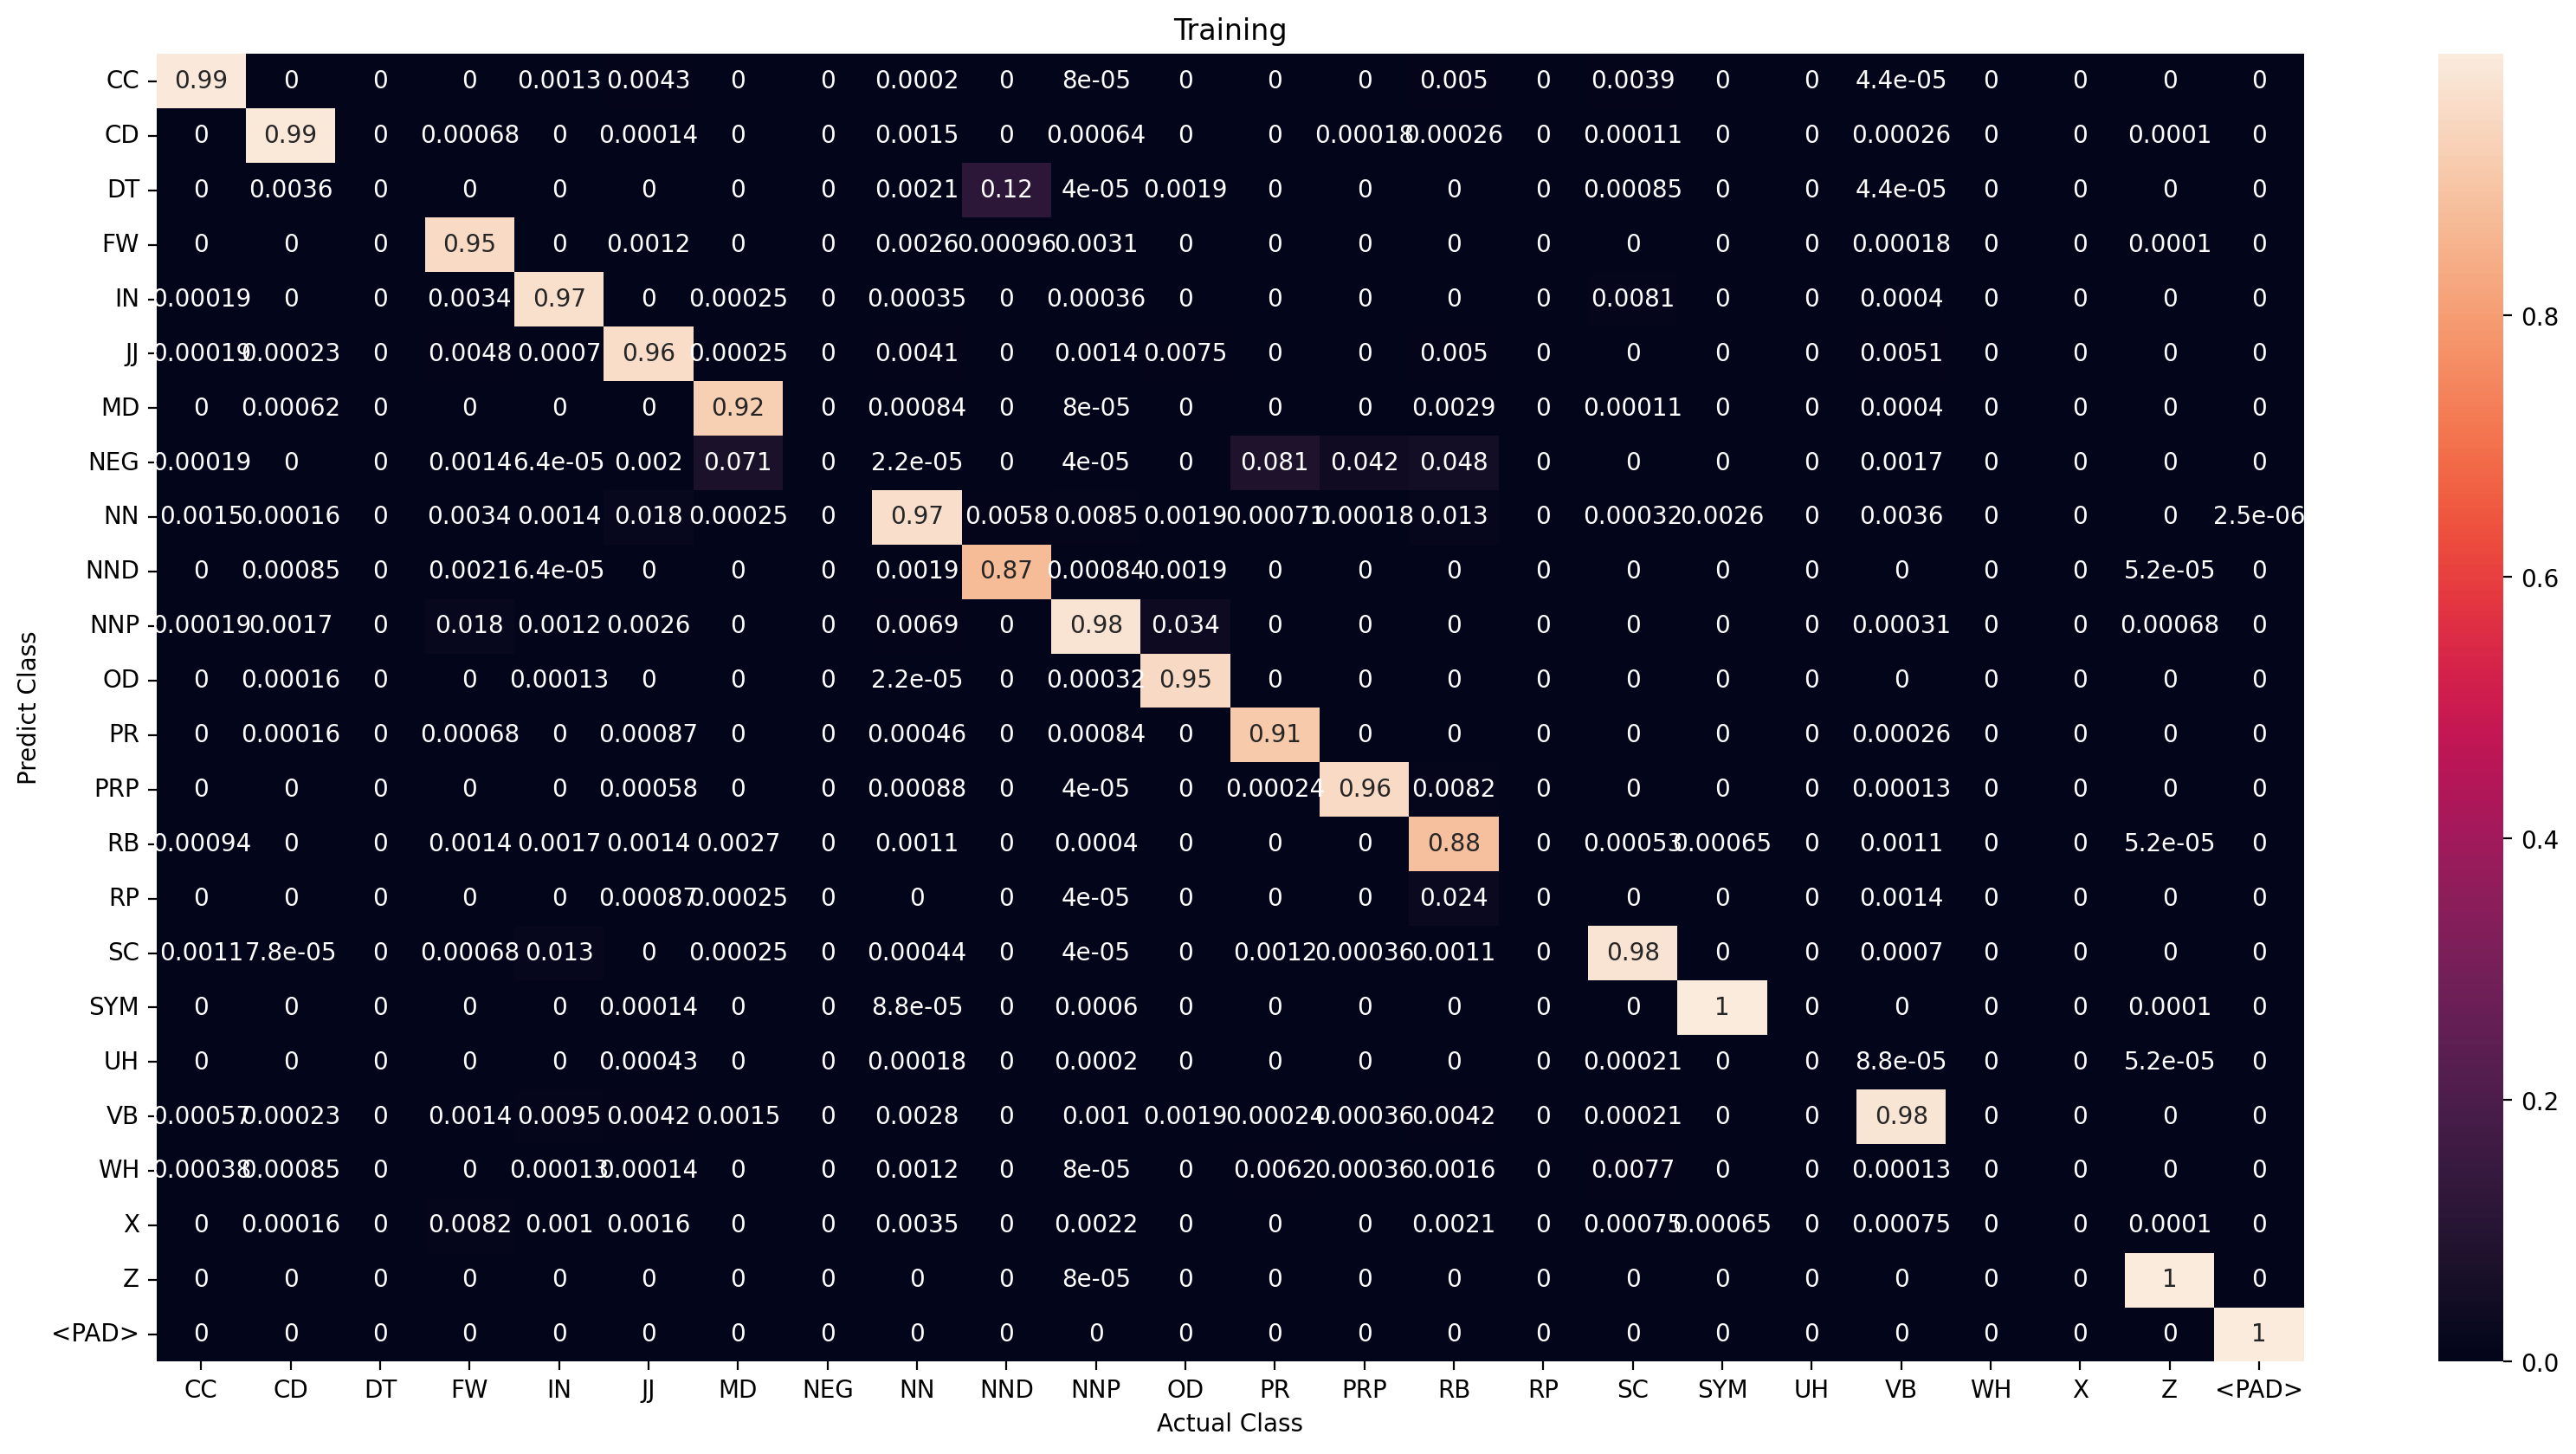

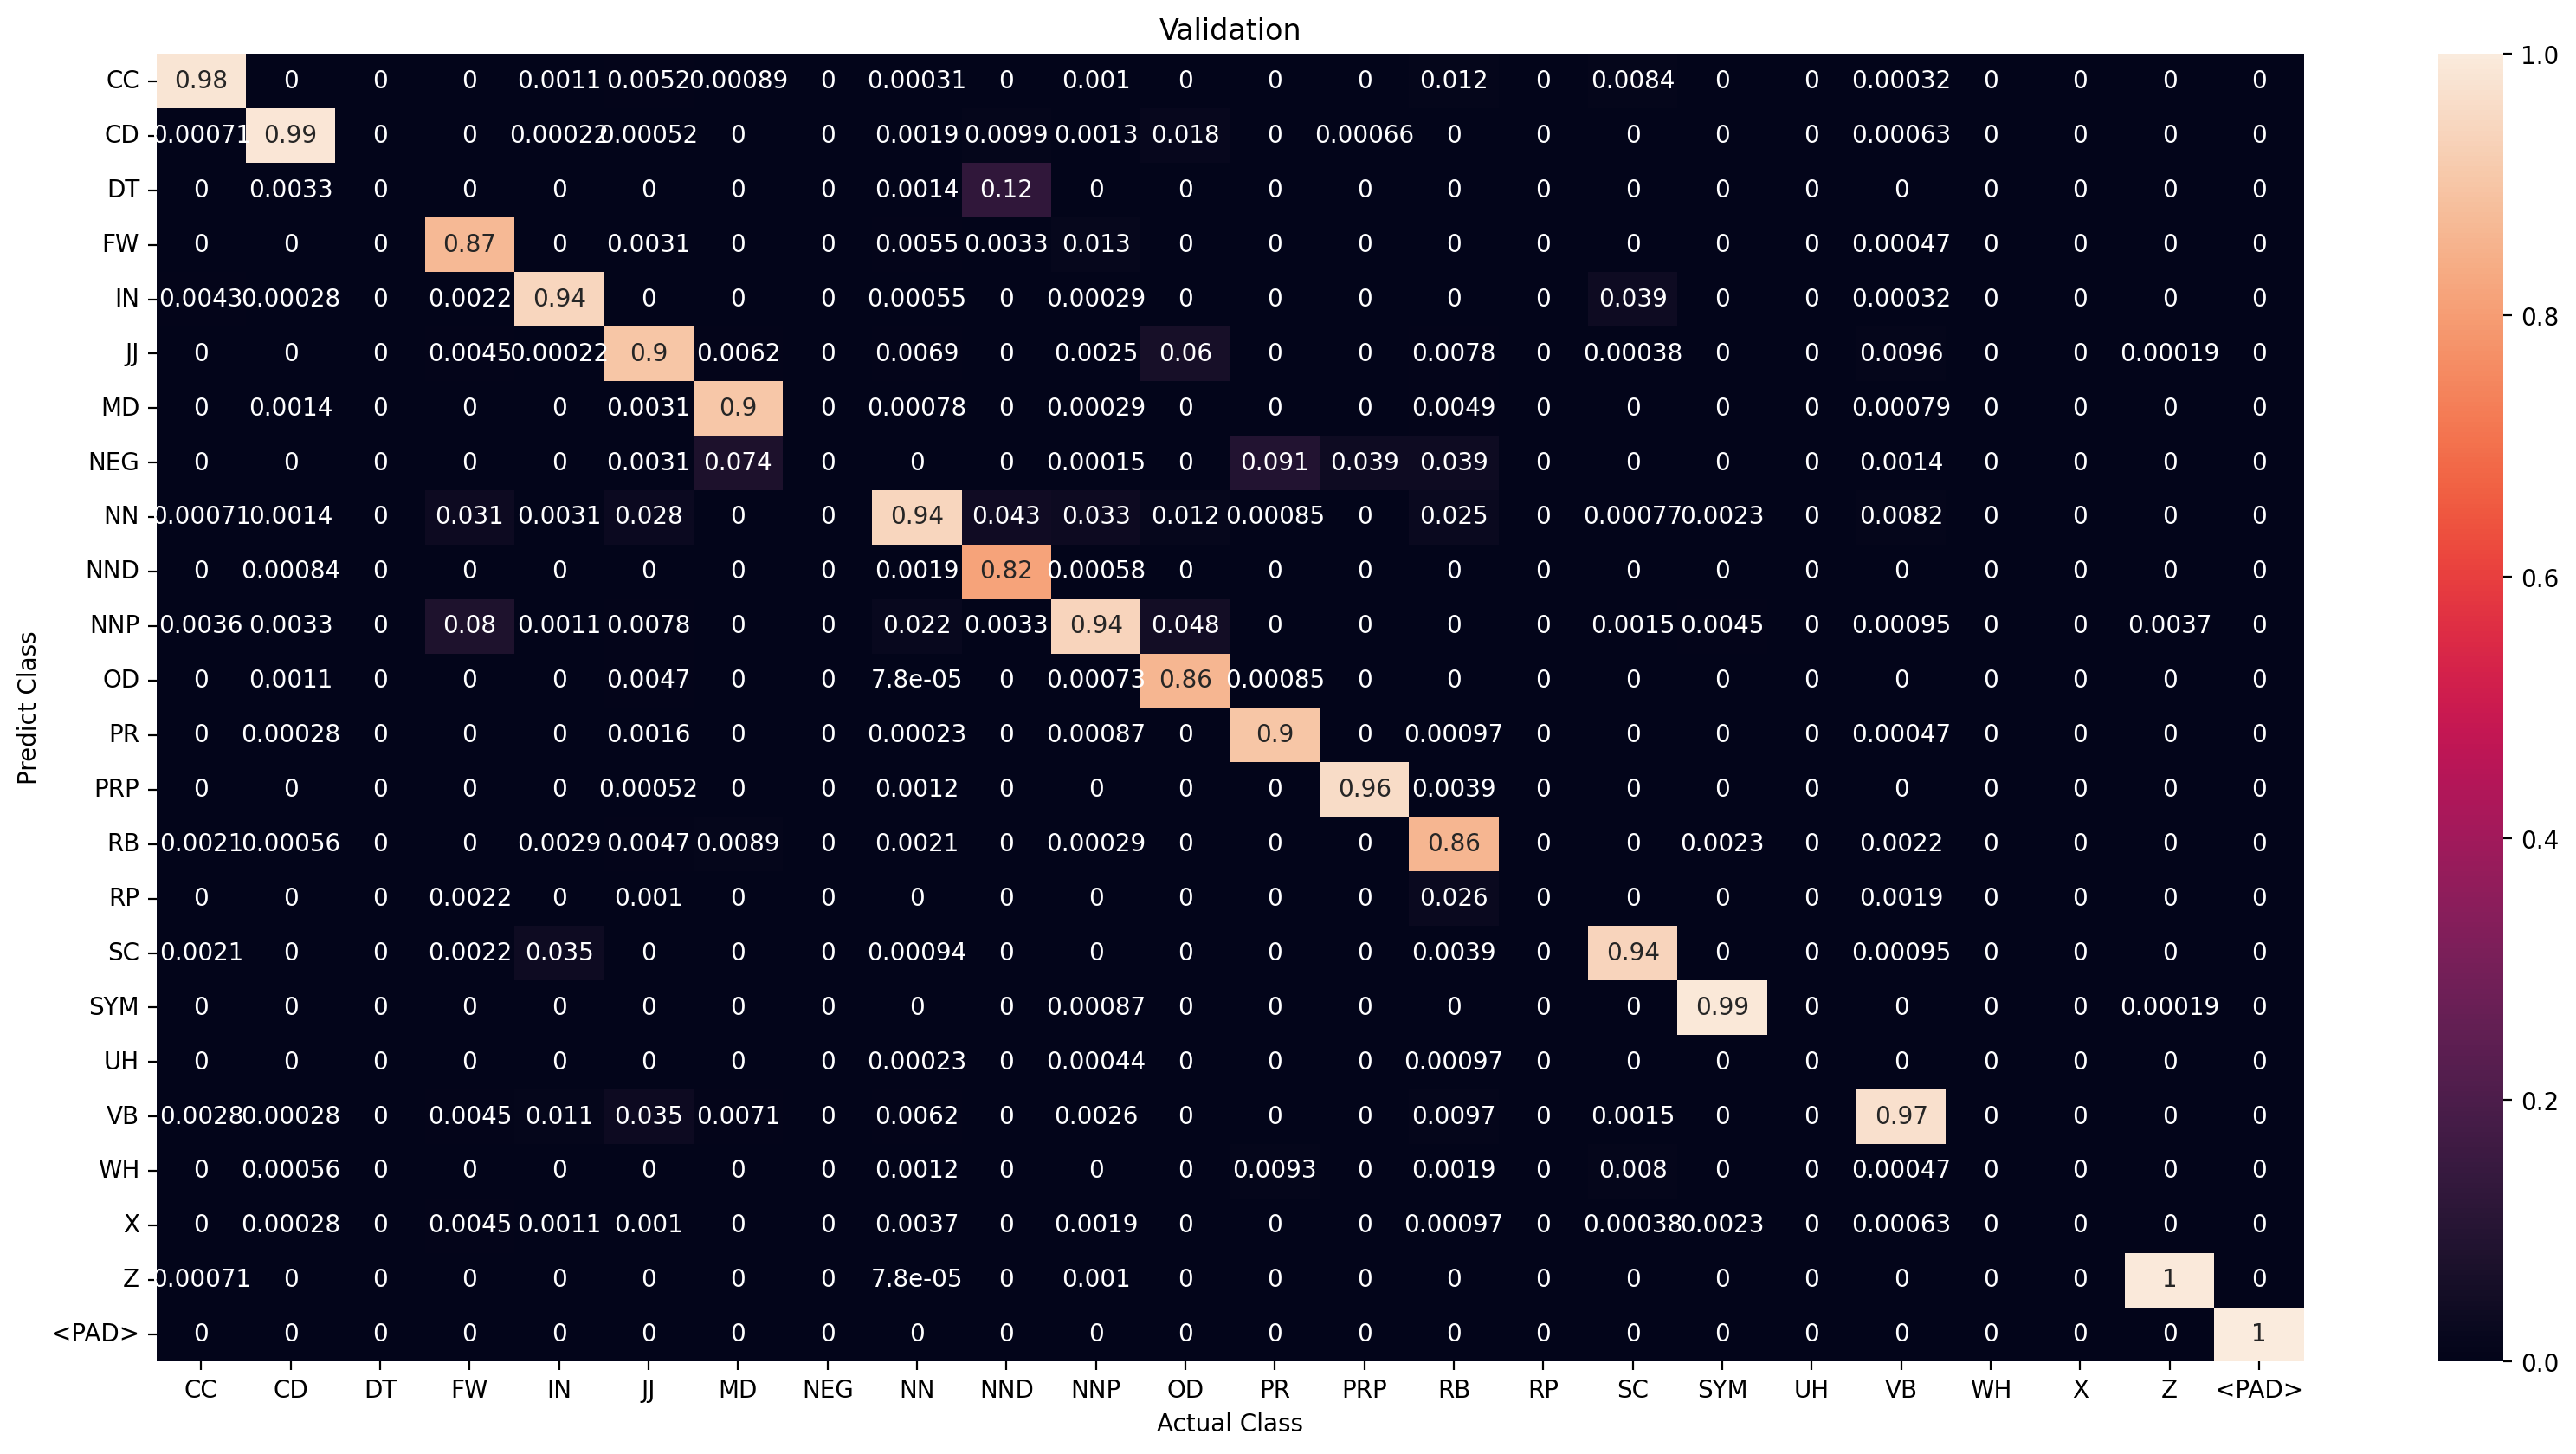

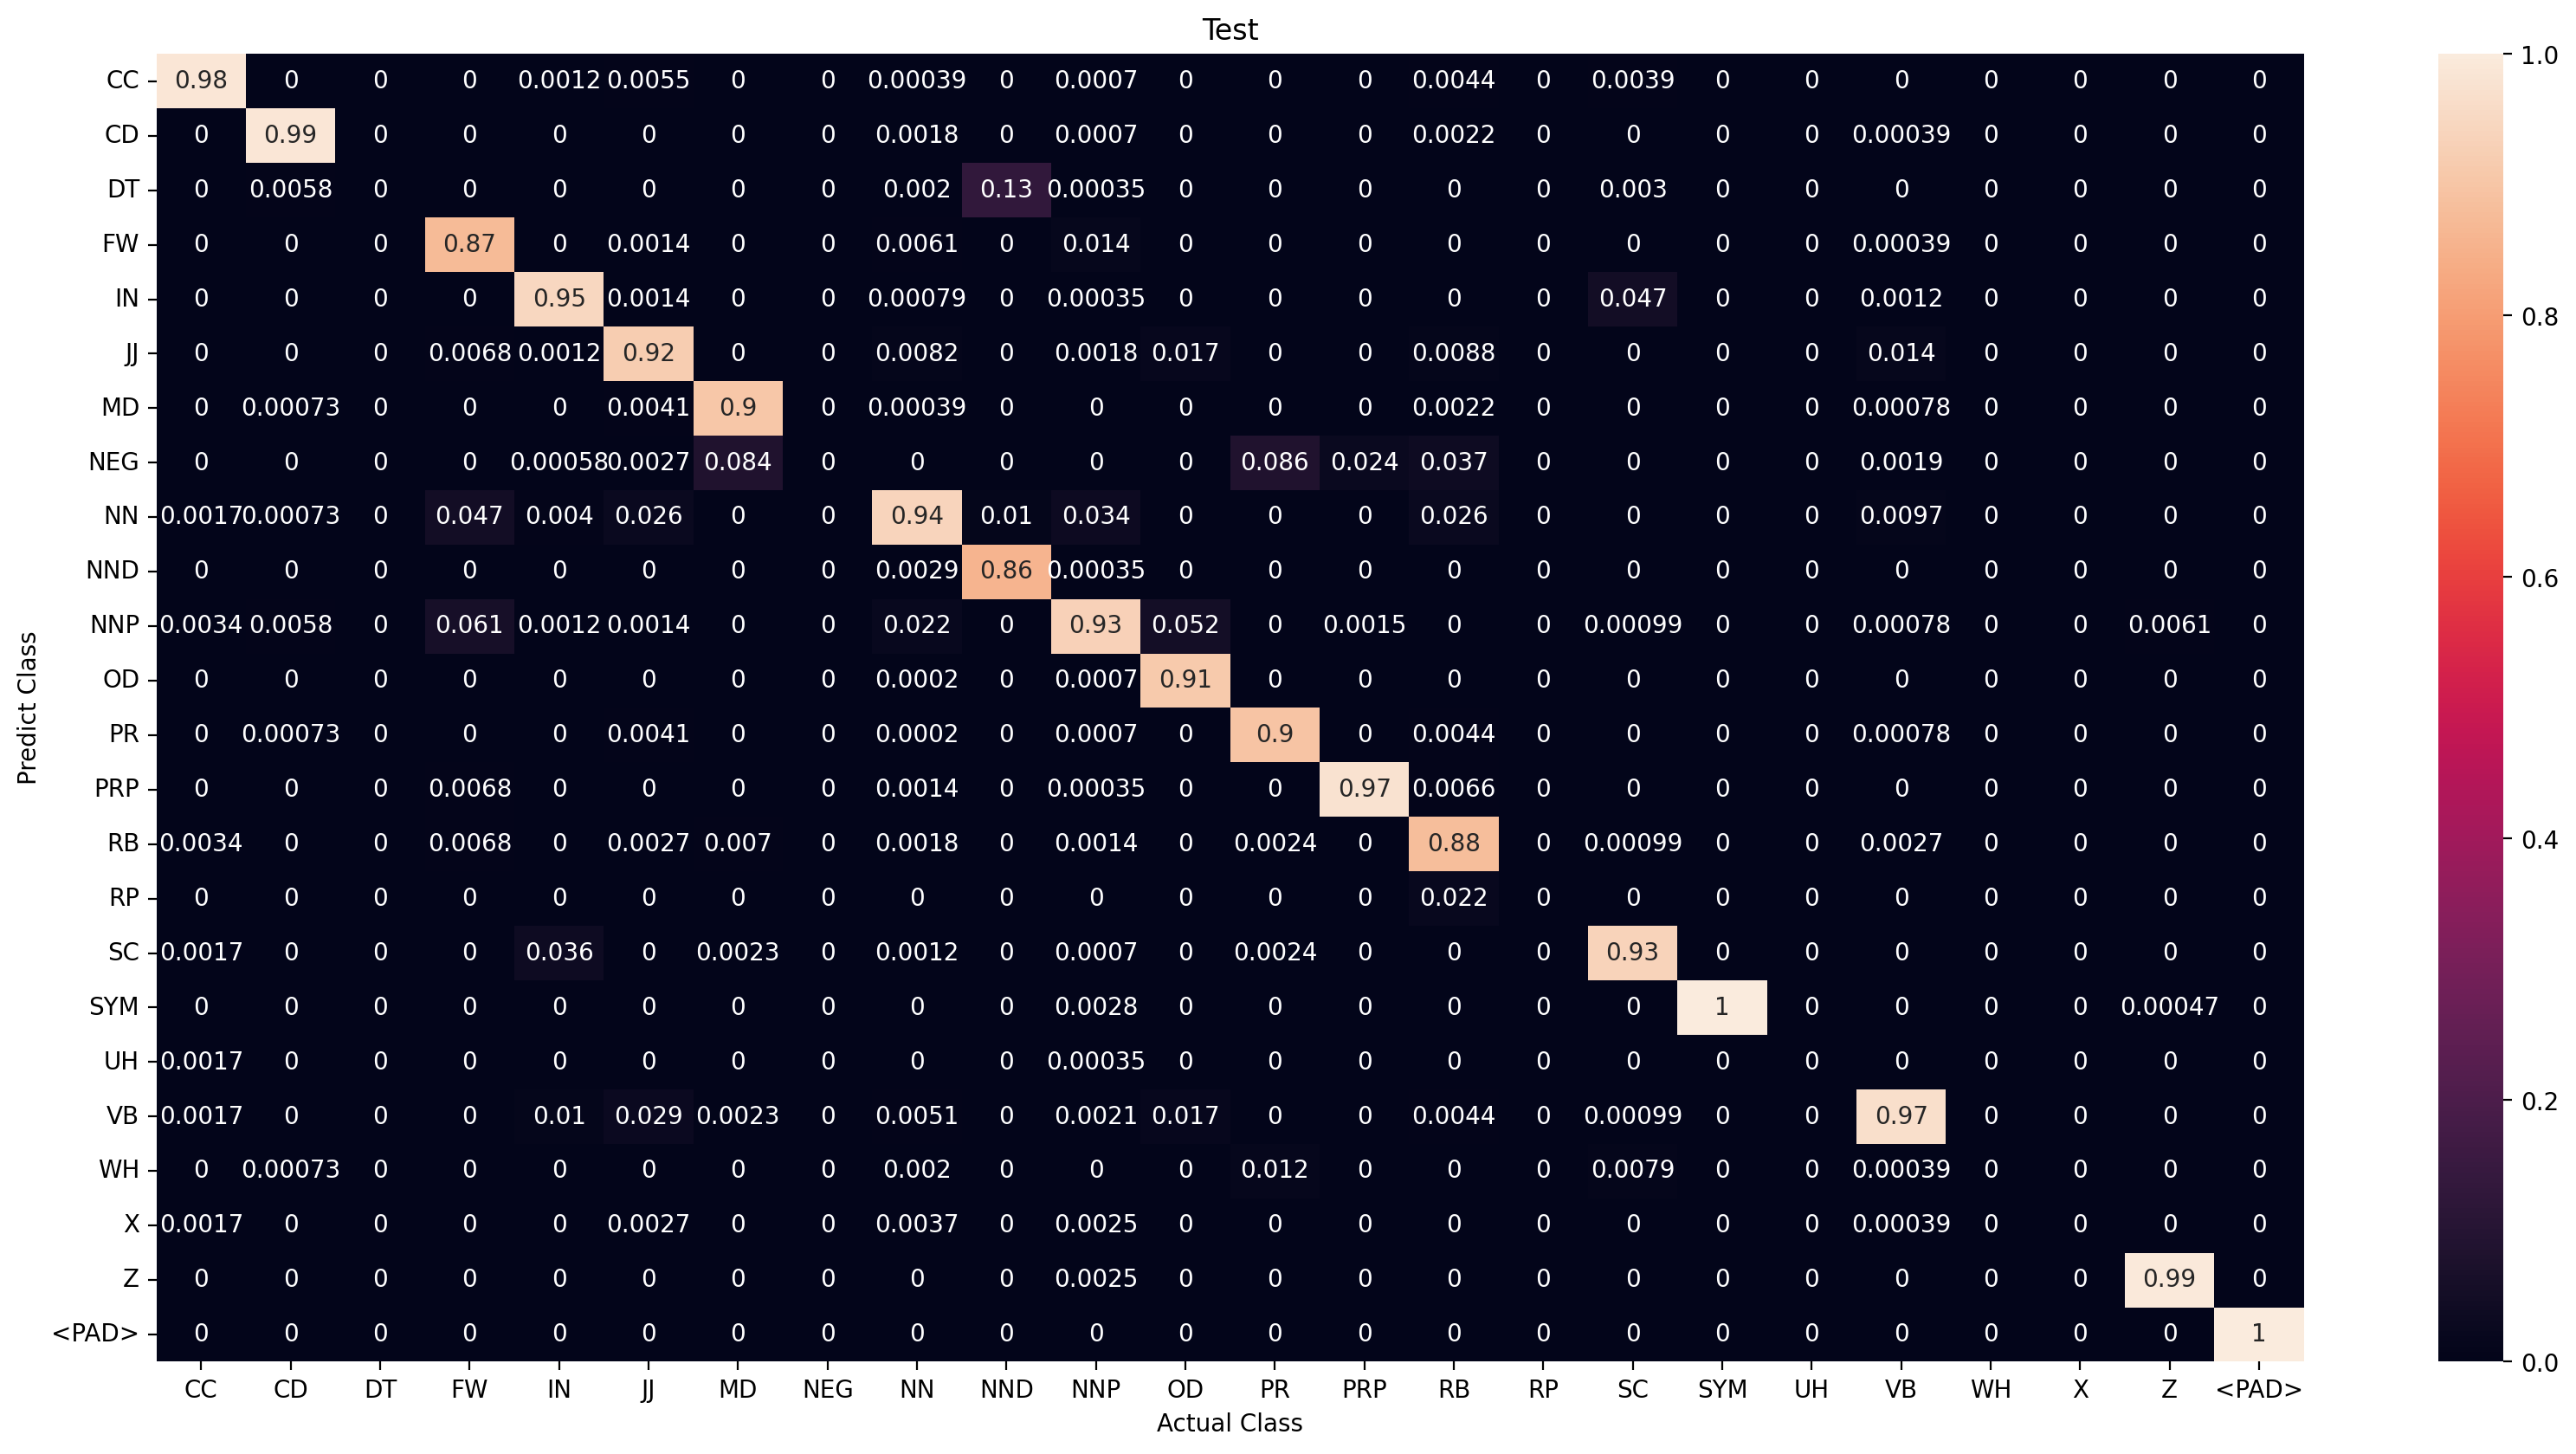

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5278       | CC    : 119      |
| CD    : 12862  | CD    : 12767      | CD    : 95       |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1393       | FW    : 212      |
| IN    : 15290  | IN    : 15173      | IN    : 117      |
| JJ    : 7025   | JJ    : 6641       | JJ    : 384      |
| MD    : 3798   | MD    : 3729       | MD    : 69       |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43946      | NN    : 526      |
| NND   : 1033   | NND   : 911        | NND   : 122      |
| NNP   : 25007  | NNP   : 24567      | NNP   : 440      |
| OD    : 519    | OD    : 506        | OD    : 13       |
| PR    : 3880   | PR    : 3823       | PR    : 57       |
| PRP   : 5449   | PRP   : 5369       | PRP   : 80       |
| RB    : 3502   | RB    : 3353       | RB    : 149      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11314
Wrong prediction            : 657
Percentage correct oov pred : 94.5117366970178

Validation
Number OOV token            : 3190
Correct prediction          : 2863
Wrong prediction            : 327
Percentage correct oov pred : 89.74921630094043

Test
Number OOV token            : 1401
Correct prediction          : 1253
Wrong prediction            : 148
Percentage correct oov pred : 89.4361170592434



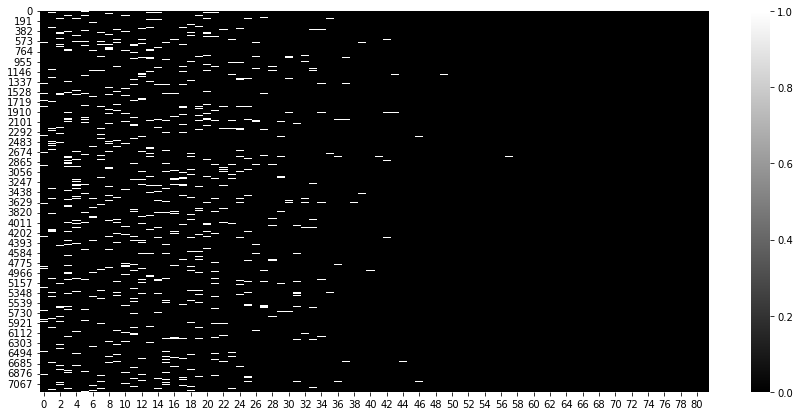

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

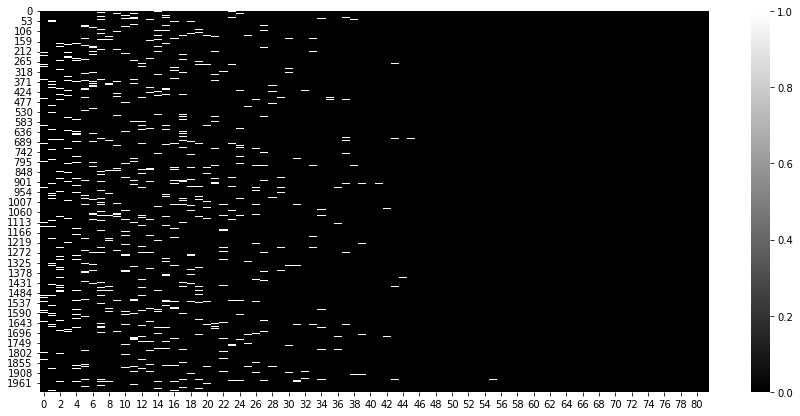

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

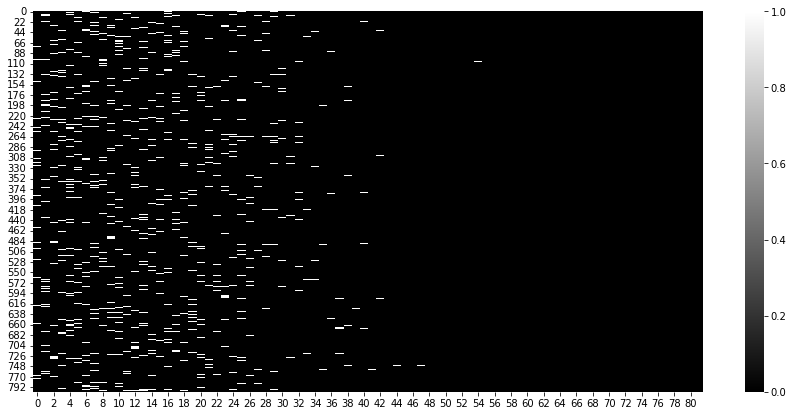

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);